<h3>Problem Statement</h3>
Your client is an Insurance company and they need your help in building a model to predict the propensity to pay renewal premium and build an incentive plan for its agents to maximise the net revenue (i.e. renewals - incentives given to collect the renewals) collected from the policies post their issuance.

 

You have information about past transactions from the policy holders along with their demographics. The client has provided aggregated historical transactional data like number of premiums delayed by 3/ 6/ 12 months across all the products, number of premiums paid, customer sourcing channel and customer demographics like age, monthly income and area type.

 

In addition to the information above, the client has provided the following relationships:

Expected effort in hours put in by an agent for incentives provided; and
Expected increase in chances of renewal, given the effort from the agent.
 

Given the information, the client wants you to predict the propensity of renewal collection and create an incentive plan for agents (at policy level) to maximise the net revenues from these policies.

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
#unzip Autopilot folder as data is inside there
!cp  /content/drive/Hackthon/McKinsey_Analytics/* .


In [0]:
!ls 

01_McKinsey_Analytics.ipynb  drive			    test_66516Ee.csv
datalab			     sample_submission_sLex1ul.csv  train_ZoGVYWq.csv



<h1>3. Exploratory Data Analysis</h1>
<h3>3.1. Import All required Classed first</h3>


In [0]:
import numpy as np
import pandas as pd
import os, shutil
from keras.models import Model
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D,BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense,Input,ELU
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from scipy import pi
import matplotlib.pyplot as plt
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D
from keras.regularizers import l2
from keras.optimizers import Adam

from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras import layers
from keras.layers import Input, Dense, Dropout,LeakyReLU,BatchNormalization
from keras import backend as K
from sklearn.model_selection import train_test_split
import bisect
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from keras.models import load_model
from keras import regularizers
from keras.optimizers import Adam
from numpy import argmax

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [0]:
Data = pd.read_csv("train_ZoGVYWq.csv")

In [0]:
print(Data.shape)
print(Data.columns)

(79853, 13)
Index(['id', 'perc_premium_paid_by_cash_credit', 'age_in_days', 'Income',
       'Count_3-6_months_late', 'Count_6-12_months_late',
       'Count_more_than_12_months_late', 'application_underwriting_score',
       'no_of_premiums_paid', 'sourcing_channel', 'residence_area_type',
       'premium', 'renewal'],
      dtype='object')


In [0]:
print(Data.describe())

                  id  perc_premium_paid_by_cash_credit   age_in_days  \
count   79853.000000                      79853.000000  79853.000000   
mean    57167.166368                          0.314288  18846.696906   
std     32928.970160                          0.334915   5208.719136   
min         2.000000                          0.000000   7670.000000   
25%     28640.000000                          0.034000  14974.000000   
50%     57262.000000                          0.167000  18625.000000   
75%     85632.000000                          0.538000  22636.000000   
max    114076.000000                          1.000000  37602.000000   

             Income  Count_3-6_months_late  Count_6-12_months_late  \
count  7.985300e+04           79756.000000            79756.000000   
mean   2.088472e+05               0.248671                0.078188   
std    4.965826e+05               0.691468                0.436507   
min    2.403000e+04               0.000000                0.000000   
2

In [0]:
print(Data.count())

id                                  79853
perc_premium_paid_by_cash_credit    79853
age_in_days                         79853
Income                              79853
Count_3-6_months_late               79756
Count_6-12_months_late              79756
Count_more_than_12_months_late      79756
application_underwriting_score      76879
no_of_premiums_paid                 79853
sourcing_channel                    79853
residence_area_type                 79853
premium                             79853
renewal                             79853
dtype: int64


In [0]:
print(Data.nunique())             

id                                  79853
perc_premium_paid_by_cash_credit     1001
age_in_days                           833
Income                              24165
Count_3-6_months_late                  14
Count_6-12_months_late                 17
Count_more_than_12_months_late         10
application_underwriting_score        672
no_of_premiums_paid                    57
sourcing_channel                        5
residence_area_type                     2
premium                                30
renewal                                 2
dtype: int64


In [0]:
print(Data.head(10))

       id  perc_premium_paid_by_cash_credit  age_in_days  Income  \
0  110936                             0.429        12058  355060   
1   41492                             0.010        21546  315150   
2   31300                             0.917        17531   84140   
3   19415                             0.049        15341  250510   
4   99379                             0.052        31400  198680   
5   59951                             0.540        17527  282080   
6   54031                             1.000        24829  118400   
7   94290                             1.000        21911  180240   
8   93730                             0.621         9868   92520   
9   84844                             0.908        23008  107180   

   Count_3-6_months_late  Count_6-12_months_late  \
0                    0.0                     0.0   
1                    0.0                     0.0   
2                    2.0                     3.0   
3                    0.0                   

In [0]:
print("No of 0's in renewal")
print(len(Data.loc[Data.renewal==0]))
print("No of 1's in renewal")
print(len(Data.loc[Data.renewal==1]))

No of 0's in renewal
4998
No of 1's in renewal
74855


Highly imbalance Data we have 

In [0]:
#Combining months late feature
Data['count_month_late'] = 20*Data["Count_3-6_months_late"] + 30*Data["Count_6-12_months_late"]+50*Data["Count_more_than_12_months_late"]

In [0]:
#re aranging values 0-1
Data['count_month_late']=Data['count_month_late']/Data['count_month_late'].max()

In [0]:
Data['count_month_late'].head()

0    0.000000
1    0.000000
2    0.264706
3    0.000000
4    0.000000
Name: count_month_late, dtype: float64

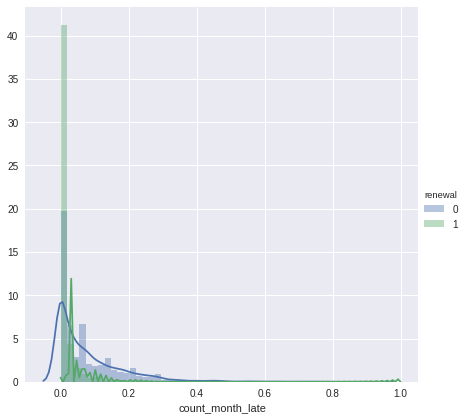

In [0]:
sns.FacetGrid(Data, hue="renewal", size=6,) \
   .map(sns.distplot, "count_month_late",) \
   .add_legend();
plt.show();


In [0]:
# converting age i day into year
Data["age_in_years"] = Data["age_in_days"]/(30*12)

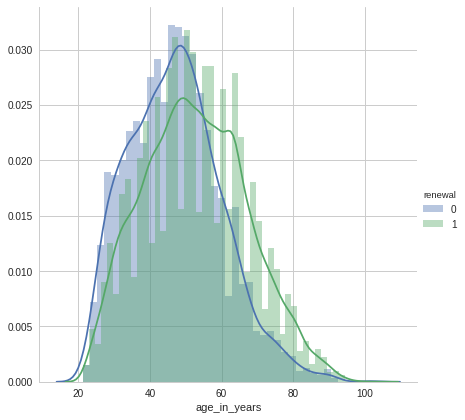

In [0]:
sns.set_style("whitegrid",);

sns.FacetGrid(Data, hue="renewal", size=6,) \
   .map(sns.distplot, "age_in_years",) \
   .add_legend();
plt.show()
plt.close()


In [0]:
def count_age_group(age):
   age_group=100
    
   if age<25 :
      age_group=25
   elif:
    
      

In [0]:
temp = Data.loc[:,["Count_6-12_months_late", "Count_more_than_12_months_late","renewal"]]
sns.set_style("whitegrid");
sns.pairplot(temp, hue="renewal", size=5);
plt.show()

<h2>Train Test Split</h2>

In [0]:
Data_Y = Data.renewal

In [0]:
train_xs,test_xs,train_ys,test_ys = train_test_split(Data,Data_Y,test_size=0.3,random_state = 10)

In [0]:
type(train_ys)

pandas.core.series.Series

In [0]:
print("No of 0's in Train")
print(len(train_ys.loc[train_ys==0]))
print("No of 1's in Train")
print(len(train_ys.loc[train_ys==1]))

No of 0's in Train
3498
No of 1's in Train
52399
